## Contents

### [Fig. 1](#fig1)

### [Fig. 2](#fig2)

### [Fig. 3](#fig3)

### [Fig. 4](#fig4)

In [200]:
# !pip install pyro-ppl==1.8.0

# !pip install ruamel.yaml

# !pip install monty spglib seaborn graphviz

# !pip install -U numpy

In [202]:
%matplotlib inline
import matplotlib as mpl
import matplotlib
from importlib import reload
from xrdc import pyromixture as pm

reload(pm)
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pyro
import numpy as np

In [246]:
plate = pyro.render_model(pm.dummy_model, model_args=(None,), filename='plate.pdf')

## Fig. 2
<a id='fig2'></a>

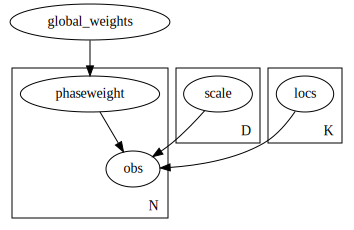

In [247]:
plate

In [13]:
alphas = np.logspace(-1, 1, 100)

In [ ]:
# Create a bunch of datasets and run VI once for each
alphas, scales, runs, runoutputs = pm.gridscan_alpha(alphas = alphas, random_scale=True)

In [19]:
# Run HMC 3 times for each of the above datasets
def rerun(alphas, res_noise, seed, inference_posterior_fn=pm.vi_inference,
         warmup = False):
    newres = []
    pyro.set_rng_seed(seed)
    for a, ddict in zip(alphas, res_noise):
        newres.append(
            pm.Run(a, datadict = ddict, noise_scale = ddict['noise_scale'],
                inference_posterior_fn=inference_posterior_fn,
                num_samples = 50, warmup = warmup).run())
    return newres

start_seed = 0

reruns_mcmc = []
for i in range(3):
    reruns_mcmc.append(rerun(alphas, runoutputs, start_seed + i, pm.mcmc_posterior,
               warmup = False))

Sample: 100%|██████████████████████████████████████████| 100/100 [01:50,  1.11s/it, step size=3.57e-02, acc. prob=0.813]                                                                                    


Warmup:  23%|█████████▉                                 | 23/100 [00:30,  1.98s/it, step size=2.54e-03, acc. prob=0.759]                                                                                    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sample: 100%|██████████████████████████████████████████| 100/100 [01:38,  1.02it/s, step size=1.95e-02, acc. prob=0.936]                                                                                    


Warmup:  32%|█████████████▊                             | 32/100 [01:01,  3.39s/it, step size=3.15e-03, acc. prob=0.771]                                                                                    

KeyboardInterrupt: 

In [ ]:
# Run VI 10 times for each of the above datasets
reruns_vi = []
for i in range(10):
    reruns_vi.append(rerun(alphas, runoutputs, start_seed + i, warmup = False))

## Fig. 1
<a id='fig1'></a>

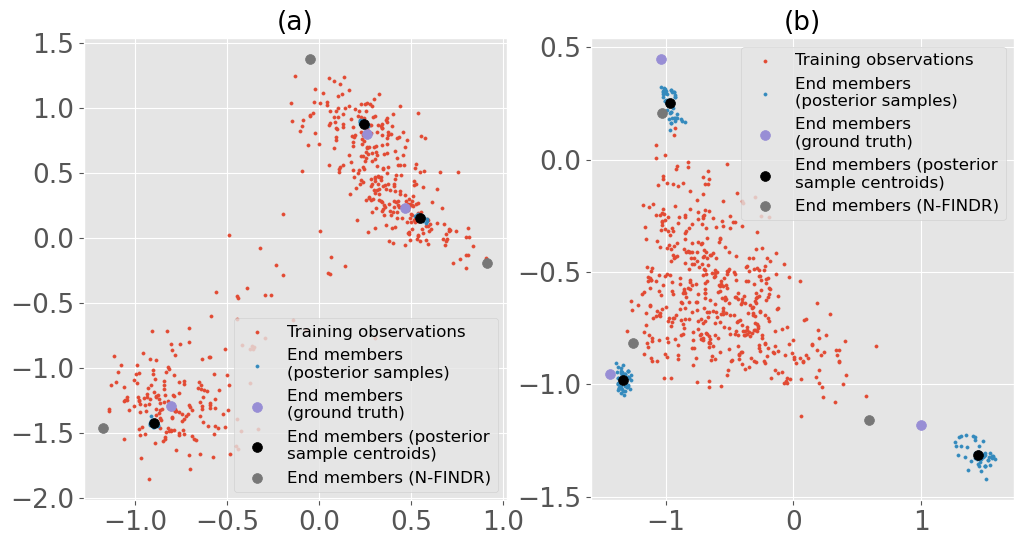

In [245]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

size2 = 19

mpl.rcParams['xtick.labelsize'] = size2 
mpl.rcParams['ytick.labelsize'] = size2 
mpl.rcParams['axes.labelsize'] = size2
mpl.rcParams['axes.titlesize'] = size2


mpl.rcParams['figure.figsize'] =(12, 6)
a, b = 1, 2

plt.subplot(a, b, 1)

pm.ploti2(best_run_mcmc, 0, with_nfindr = True, loc = 'lower right')
plt.title('(a)')

plt.subplot(a, b, 2)
plt.title('(b)')
pm.ploti2(best_run_mcmc, 93, with_nfindr = True, loc = 'upper right')
plt.savefig('nips_fig1.pdf')

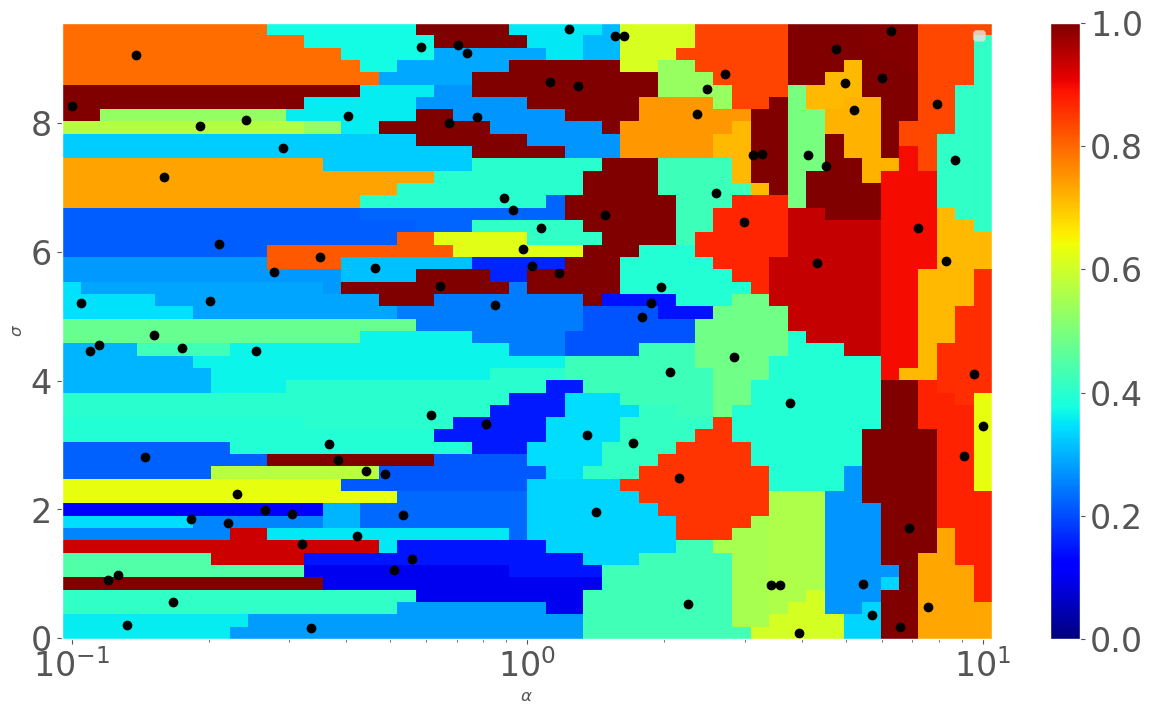

In [240]:
[append_scores(runs, score_run_loss, 'score') for runs in reruns_vi]
best_run_vi = select_best_runs(reruns_vi)
pm.plt_heatmap_alpha_noise(best_run_vi, alphas);

In [113]:
# import dill
# with open('mcmc.dill', 'rb') as f:
#     reruns_mcmc = dill.load(f)

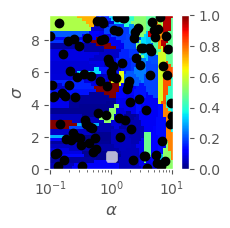

array([0.2135012 , 0.06929898, 0.09574382, 1.1868944 , 0.12981683,
       0.08727125, 0.04845051, 0.56204414, 1.0234032 , 0.14402445,
       0.0874231 , 0.02922557, 0.06217109, 0.13168992, 0.17265849,
       0.15834221, 0.07514261, 0.03058909, 0.06366058, 0.12591197,
       0.02552191, 0.2994302 , 0.07988083, 0.03241942, 0.01257602,
       0.05519835, 0.10667866, 0.34283018, 0.05579171, 0.2952479 ,
       0.12007307, 0.02303275, 0.19246876, 0.05389782, 0.04059206,
       0.01879179, 0.01859435, 0.03532868, 0.7196937 , 0.01865485,
       0.08294332, 3.261473  , 0.16271095, 0.0701356 , 0.10075445,
       0.52083695, 1.4113921 , 0.06407204, 0.08612578, 0.14305143,
       0.0650325 , 0.0601962 , 0.18905249, 0.6275375 , 0.32829797,
       0.18336181, 0.07838681, 0.05837077, 0.15675183, 0.36077774,
       0.40283212, 0.02551764, 0.1158763 , 0.10590252, 0.21307929,
       0.0950239 , 0.04422855, 0.05125954, 0.19495675, 0.26200646,
       0.17769885, 0.5159203 , 0.14066078, 0.24884818, 0.50324

In [25]:
def append_scores(runlist, score_fn, keyname = 'score'):
    for run in runlist:
        run[keyname] = score_fn(run)

def select_best_runs(reruns, keyname = 'score'):
    res = []
    for runs in zip(*reruns):
        res.append(max(runs, key = lambda run: run[keyname]))
    return res

# %matplotlib inline
def score_run_loss(run, istart = 0, iend = 1600):
    """
    high score means better.
    """
    #return np.mean(run['losses'][:10]) - np.mean(run['losses'][-10:])
    #return -np.mean(run['losses'][istart:defiend])
    #return (np.mean(run['log_likelihoods'][0]) - np.mean(run['log_likelihoods'][-1]))
    return np.mean(run['inference_output']['log_likelihoods'][:])

reruns = reruns_mcmc
[append_scores(runs, score_run_loss, 'score') for runs in reruns]
best_run_mcmc = select_best_runs(reruns)
pm.plt_heatmap_alpha_noise(best_run_mcmc, alphas);

In [417]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] =(8, 8)

In [167]:
ll_mcmc = np.median([run['inference_output']['log_likelihoods'][-1] for run in best_run_mcmc])
#ll_vi = np.median([run['inference_output']['log_likelihoods'][-1] for run in best_run_vi2])
format(ll_mcmc,'.2E')#, format(ll_vi,'.2E')

'3.74E+04'

In [164]:
n_samples = 20
ll_nfindr = []
for elt in best_run_mcmc:
    locs = torch.Tensor(pm.nfindr_locs(elt['data']))
    # condition on N-FINDER's end member coordinates
    conditioned = pyro.condition(elt['model'], data = {'locs': locs})

    slocs = torch.zeros([n_samples, locs.shape[0], locs.shape[1]])
    slocs[:] = locs
    posterior_fn = pm.mcmc_posterior(elt['data'], n_samples, pm.N, elt['alpha'], elt['noise_scale'],
                                     pm.NUTS(conditioned), locs = slocs, warmup_steps=20)
    ll_nfindr.append(posterior_fn['log_likelihoods'][-1])

Sample: 100%|████████████████████████████████████████████| 40/40 [00:06,  5.73it/s, step size=1.67e-01, acc. prob=0.153]                                                                                    


Sample: 100%|████████████████████████████████████████████| 40/40 [00:08,  4.72it/s, step size=9.94e-02, acc. prob=0.626]                                                                                    


## Fig. 3
<a id='fig3'></a>

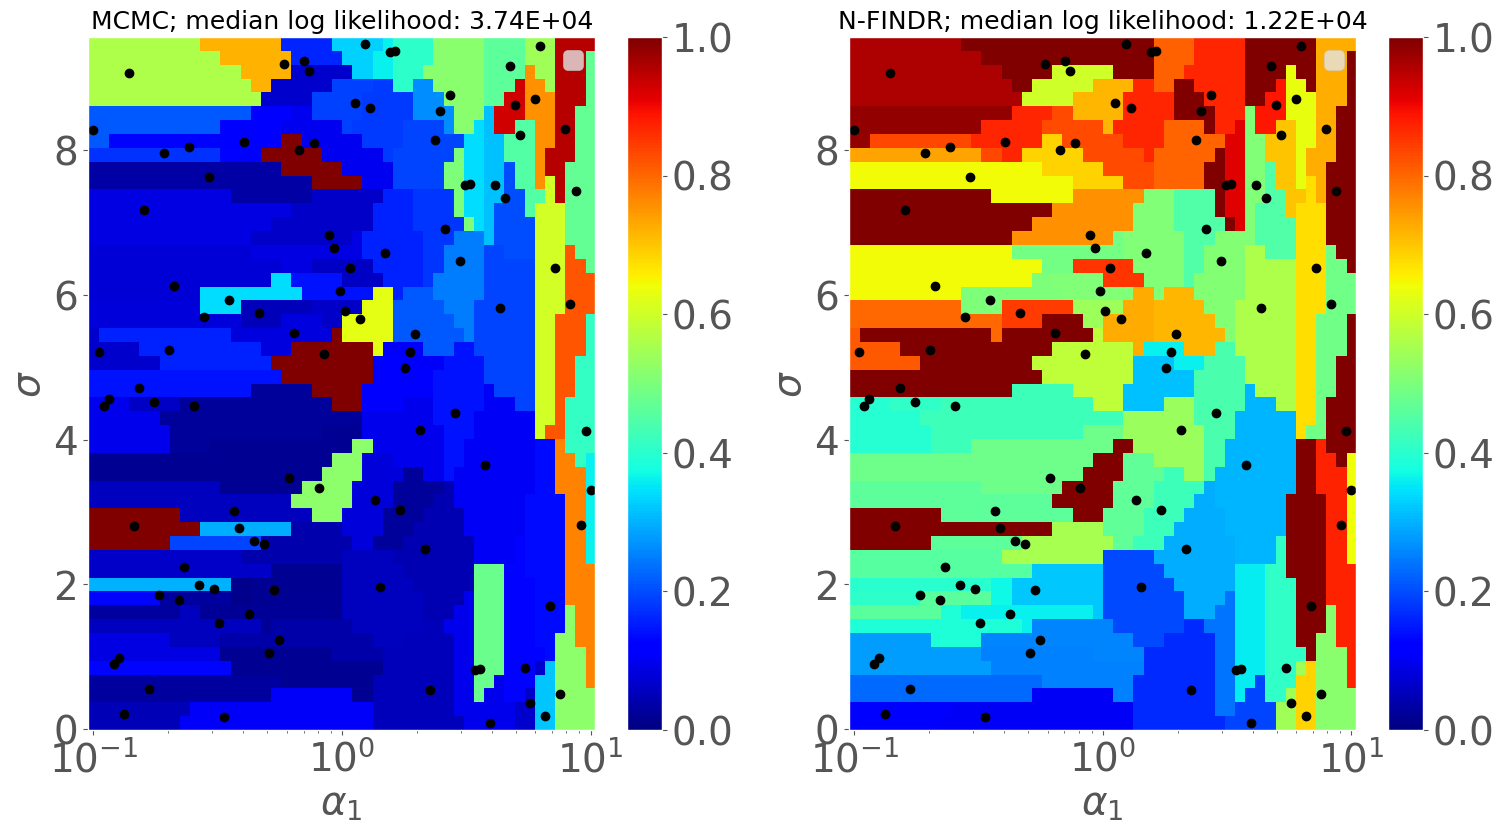

In [243]:
matplotlib.rcParams['figure.figsize'] =(18, 9)

size2 = 28
size1 = 18
plt.rcParams.update({'font.size': size1})
plt.rcParams.update({'axes.labelsize': size2})
plt.rcParams.update({'axes.titlesize': size1})
plt.rcParams.update({'xtick.labelsize': size2})
plt.rcParams.update({'ytick.labelsize': size2})

[append_scores(runs, score_run_loss, 'score') for runs in reruns_mcmc]

best_run_mcmc = select_best_runs(reruns_mcmc)

a, b = 1, 2
plt.subplot(a, b, 1)

zmc = pm.plt_heatmap_alpha_noise(best_run_mcmc, alphas,
                           label = 'MCMC; median log likelihood: {:.2E}'.format(ll_mcmc))

plt.subplot(a, b, 2)
znfindr = pm.plt_heatmap_alpha_noise(best_run_mcmc, alphas, zname = 'diff_locs_nfindr',
                                    label = 'N-FINDR; median log likelihood: {:.2E}'.format(np.median(ll_nfindr)))

plt.savefig('nips_fig4.pdf')


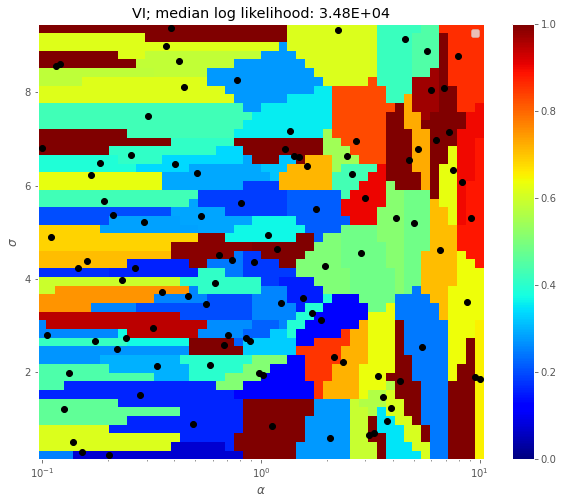

In [641]:
zvi = pm.plt_heatmap_alpha_noise(best_run_vi, alphas,
                           label = 'VI; median log likelihood: {:.2E}'.format(ll_vi))

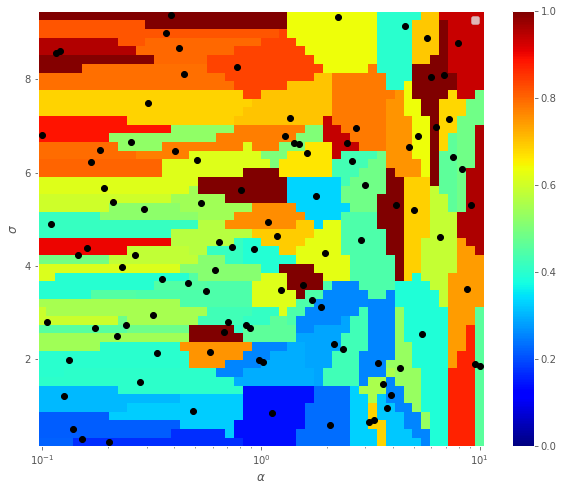

In [649]:
znfindr = pm.plt_heatmap_alpha_noise(best_run_mcmc, alphas, zname = 'diff_locs_nfindr')

In [183]:
# local_weights = reruns[0][0]['samples']['phase_weights']
# locs = reruns[0][0]['samples']['locs']

# data = reruns[0][0]['data']

# L_omega = reruns[0][0]['samples']['L_omega']

# scales = reruns[0][0]['samples']['scales']#.keys()

# L_Omega = torch.einsum('mij,mlij -> mlij',
#              torch.einsum('ij,mj -> mij', torch.eye(pm.ndim), scales.sqrt()),
#              torch.einsum('ljik,lnj->lnik', L_omega, local_weights))

# local_weights = reruns[0][0]['samples']['phase_weights']
# locs = reruns[0][0]['samples']['locs']
# weighted_expectation = torch.einsum('kji,klj->kli', locs, local_weights)

# log_likelihood = (pm.dist.MultivariateNormal(weighted_expectation, scale_tril=L_Omega)
#           .log_prob(data).sum().item())

In [217]:
def get_inferred_locs(runoutput: dict):
    loc_stds = np.linalg.norm(runoutput['posterior_locs'].std(axis = (0)), axis = 1) / np.sqrt(2)#np.linalg.norm(runoutput['posterior_locs'].std(axis = 0)) / np.sqrt(6)#runoutput['posterior_locs'].std(axis = (0, 2))
    loc_mus = runoutput['centroid_mu_posterior'][runoutput['permutation'], :]
    loc_ground = np.array(runoutput['locs'])

    
    loc_mus = loc_mus.ravel()
    loc_ground = loc_ground.ravel()
    
    return ({'loc mu': loc_mus},
            {'loc std': loc_stds},
            {'loc ground': loc_ground})

def inference_stats(runoutput: dict):
    loc_stds = np.linalg.norm(runoutput['posterior_locs'].std(axis = (0)), axis = 1) / np.sqrt(2)#np.linalg.norm(runoutput['posterior_locs'].std(axis = 0)) / np.sqrt(6)#runoutput['posterior_locs'].std(axis = (0, 2))
    loc_mus = runoutput['centroid_mu_posterior'][runoutput['permutation'], :]
    loc_ground = np.array(runoutput['locs'])

    weight_stds = runoutput['inference_output']['predictive']['weights'].std(axis = 0)
#     weight_mus = np.array(runoutput['inference_output']['predictive']['weights'][0]
#                   .mean(axis = 0)
    weight_mus = np.array(runoutput['inference_output']['predictive']['weights']
                  .mean(axis = 0)
                  [[runoutput['permutation']]])
    weight_ground = np.array(runoutput['weights'])[0]
    
    loc_mus = loc_mus.ravel()
    loc_ground = loc_ground.ravel()
    
    return ({'loc mu': loc_mus, 'weight mu': weight_mus},
            {'loc std': loc_stds, 'weight std': weight_stds},
            {'loc ground': loc_ground, 'weight ground': weight_ground})

def fmt_stats(runoutput, weight = True, mode = 'sampling'):
    #print(runoutput['alpha'])
    if mode == 'sampling':
        if weight:
            mus, stds, grounds = inference_stats(runoutput)
        else:
            mus, stds, grounds = get_inferred_locs(runoutput)
        data = pairjoin(grounds['loc ground'],mus['loc mu'],  '$\mu$', runoutput['alpha'])
        if weight:
            data = {**data, **pairjoin(grounds['weight ground'], mus['weight mu'], 'weight',
                                      runoutput['alpha'])}
        return data
    elif mode == 'nfindr':
        mus, _, grounds = nfindr_stats(runoutput)
        return pairjoin(grounds['loc ground'], mus['loc mu'], '$\mu$', runoutput['alpha'])
    else:
        raise ValueError

def fmt_stats_std(runoutput1, runoutput2):
    _, _, grounds1 = inference_stats(runoutput1)
    _, stds2, _ = inference_stats(runoutput2)
    datamu = pairjoin(grounds1['loc ground'], stds2['loc mu'], '$\mu$')
    #dataweight = pairjoin(grounds1['weight ground'], stds2['weight mu'], 'weight')
    #data = {**data, **data2}
    return datamu

def dmerge(d1, d2):
    for k1, v1 in d1.items():
        v1.extend(d2[k1])
    return d1

def pairjoin(pts1, pts2, label, alpha):
    return {label: [{'x': p1, 'y': p2, 'z': alpha} for p1, p2 in zip(pts1, pts2)]}

def mkscatter(data, title = None):
    #data = {'A': [{'x': 1, 'y' : 2}, {'x': 2, 'y' : 3}, {'x': 3, 'y' : 4}], 'B': [{'x': 5, 'y' : 6}, {'x': 6, 'y' : 7}, {'x': 7, 'y' : 8}], 'C': [{'x': 10, 'y' : 11}, {'x': 11, 'y' : 12}, {'x': 12, 'y' : 13}]}
    x, y, group, z = [], [], [], []
    for i in data:
        for j in data[i]:
            x.append(j['x'])
            y.append(j['y'])
            z.append(j['z'])
            group.append(i)

    plt.figure(figsize=(8,4))
    sns.lineplot([min(x), max(x)], [min(x), max(x)], color = 'k', linestyle='--')
    sns.scatterplot(x = x, y = y, hue = group).set(title = title)
    #sns.scatterplot(x = x, y = y, hue = np.log(.5 + np.array(z)), cmap = 'jet')
    #plt.savefig("fig.png")
    plt.show()

from functools import reduce

In [208]:
def get_stds(runoutput):
    return np.linalg.norm(runoutput['posterior_locs'].std(axis = (0)), axis = 1) / np.sqrt(2)

def get_inferred_locs(runoutput: dict):
    loc_stds = get_stds(runoutput)#np.linalg.norm(runoutput['posterior_locs'].std(axis = 0)) / np.sqrt(6)#runoutput['posterior_locs'].std(axis = (0, 2))
    loc_mus = runoutput['centroid_mu_posterior'][runoutput['permutation'], :]
    loc_ground = np.array(runoutput['locs'])

In [209]:
def nfindr_stats(runoutput):
    nfindr_mus = pm.nfindr_locs(runoutput['data'])
    nfindr_mus = nfindr_mus[(pm.closest_permutation(nfindr_mus, runoutput['locs']),)]
    return {'loc mu': nfindr_mus.ravel()},\
            {'loc std': None},\
            {'loc ground': np.array(runoutput['locs']).ravel()}

In [237]:
data_vi = reduce(lambda a, b: dmerge(a, b), map(lambda r: fmt_stats(r),
                                    best_run_vi))

data_nfindr = reduce(lambda a, b: dmerge(a, b), map(lambda r: fmt_stats(r, mode = 'nfindr'),
                                    reruns_mcmc[0]))

data_mcmc = reduce(lambda a, b: dmerge(a, b), map(lambda r: fmt_stats(r),
                                    best_run_mcmc))

## Fig. 4
<a id='fig4'></a>

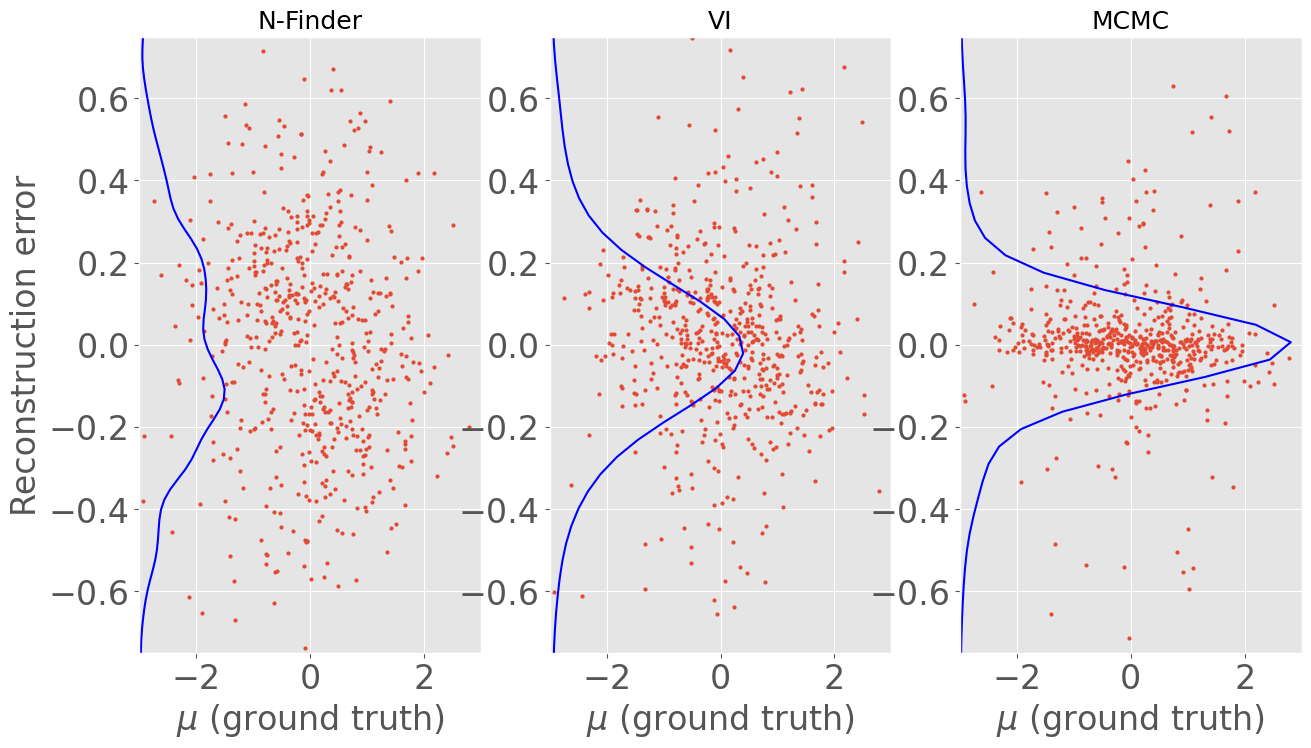

In [241]:
import pandas as pd
import matplotlib as mpl
from xrdc.source_separation import *
mpl.rcParams['figure.figsize'] =(15, 8)

size2 = 24
size1 = 18
plt.rcParams.update({'font.size': size1})
plt.rcParams.update({'axes.labelsize': size2})
plt.rcParams.update({'axes.titlesize': size1})
plt.rcParams.update({'xtick.labelsize': size2})
plt.rcParams.update({'ytick.labelsize': size2})

def plot_reconstruction_residuals(data, key = '$\\mu$'):
    diffs_mu = pd.DataFrame(data[key]).x - pd.DataFrame(data[key]).y

    mu_sorted = diffs_mu.sort_values()
    cum = np.arange(len(mu_sorted)) / len(mu_sorted)
    plt.plot(pd.DataFrame(data[key]).x, diffs_mu, 'o', markersize = 2)
    plt.ylim((-.75, .75))
    plt.xlim((-3, 3))
    
    
    x = pd.DataFrame(data['$\\mu$']).x
    y = pd.DataFrame(data['$\\mu$']).y
    y, x = np.histogram(y - x, bins = 100)
    y = y.astype(float)
    dx = np.mean(np.diff(x))
    x = x[:-1] + dx / 2
    plt.plot(gf(y, 2) / 15 - 3, x, 'blue')
    
a, b = 1, 3
plt.subplot(a, b, 1)
plot_reconstruction_residuals(data_nfindr)
plt.title('N-Finder')
plt.xlabel('$\\mu$ (ground truth)')
plt.ylabel('Reconstruction error')

plt.subplot(a, b, 2)
plot_reconstruction_residuals(data_vi)
plt.title('VI')
plt.xlabel('$\\mu$ (ground truth)')


plt.subplot(a, b, 3)
plot_reconstruction_residuals(data_mcmc)
plt.title('MCMC')
plt.xlabel('$\\mu$ (ground truth)')

plt.savefig('nips_fig3.pdf')

Miscellaneous stuff:

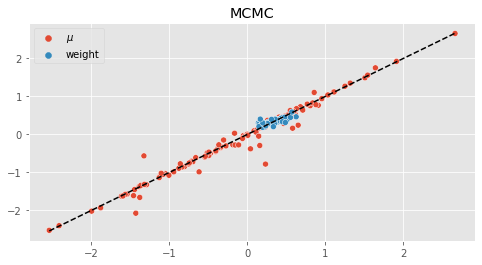

In [155]:
data = reduce(lambda a, b: dmerge(a, b), map(lambda r: fmt_stats(r),
                                    reruns_mcmc[0]))
#sns.title('MCMC')
mkscatter(data, 'MCMC')

In [61]:
# KLs = []
# ppca_outputs = []

# for res in runoutputs:
#     x_train = res['data'].T
#     #x_train = tf.cast(x_train, 'float64')
#     x_generated, w, z = pm.ppca_generated(res)
#     ppca_outputs.append({'x_train': x_train, 'x_generated': x_generated,
#                         'w': w, 'z': z})
#     #hist_train, hist_gen = pm.hist2d(x_train), pm.hist2d(x_generated)
#     #KLs.append(pm.entropy(hist_train.ravel(), hist_gen.ravel()))

# def plt_ppca(ppca_out):
#     x_train = ppca_out['x_train']
#     x_generated = ppca_out['x_generated']
#     plt.scatter(x_train[0, :], x_train[1, :], color='blue', alpha=0.1, label='Actual data')
#     plt.scatter(x_generated[0, :], x_generated[1, :], color='red', alpha=0.1, label='Simulated data (MAP)')
#     plt.legend()
#     #plt.axis([-20, 20, -20, 20])
#     plt.show()

MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.4149103 , -0.2346021 ],
       [-0.513532  , -0.56162685]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-1.0786233 ,  0.95557404],
       [ 0.7156516 , -0.6238834 ]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-1.7865585 , -0.6243956 ],
       [-1.1545137 ,  0.36755466]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.5480538 , -0.6858799 ],
       [ 0.44700688,  0.40559545]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 1.025342  , -0.36237934],
       [ 0.7240855 , -0.970891  ]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.33387178, -0.18398657],
       [ 0.5321871 , -0.639067  ]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.5268193 , -0.44699764],
       [-0.595974  ,  1.0455375 ]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.46366918,  0.8538521 ],
       [-0.09527172, -0.60668135]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.02002488, -0.12741774],
       [ 0.4812759 ,  0.6031932 ]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.26155218, -0.5223424 ],
       [ 0.152429  ,  0.07905529]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.36777303, -0.17244542],
       [-0.5752608 ,  0.22912577]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.5194845 , -0.52638644],
       [-0.6131073 ,  0.4661035 ]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.8822867 ,  0.97435457],
       [-0.02228367, -0.37456733]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[nan, nan],
       [nan, nan]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.35006732, -0.49004027],
       [ 0.37729418, -0.5567501 ]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.21264099,  0.26461646],
       [ 0.91340506, -0.84056634]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.4349285 , -0.4569343 ],
       [ 0.00771538, -0.19182637]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.22194807,  0.29111588],
       [ 0.1555747 ,  0.30008698]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.23084095, -0.5348211 ],
       [-0.3456379 ,  0.36895034]], dtype=float32)>


MAP-estimated axes:
<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[-0.22701447, -0.3819493 ],
       [-0.2868475 , -0.30061013]], dtype=float32)>


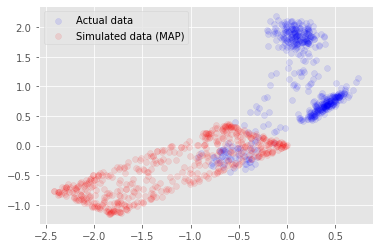

In [62]:
# plt_ppca(ppca_outputs[2])

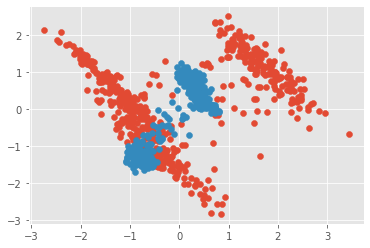

In [55]:
# plt.scatter(*ppca_outputs[0]['z'])
# plt.scatter(*ppca_outputs[0]['x_train'])